## Workflow steps

1. Problem Definition
2. Import Train and Test Set
3. Explore Data and Generate New Features
4. Feature Standardization
5. Model Training and Prediction
6. Prediction on the Test Set
7. Export the Predicted Results



## 1. Problem Definition and Goal: 
Dataset   that   contains   small   subset   of  website   visits   in the   past   two   months. <br>
Goal: Predict Customer Gender after Each Click. <br>
Approach: Solve this machine learning problem with pandas and scikit-learn. <br> 



## 2. Import train and test set

In [36]:
# Load libraries for data analysis 
import pandas as pd
import numpy as np
#from pandas.tools.plotting import scatter_matrix
# Load libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Load libraries for machine learning
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [37]:
train_data = pd.read_csv('train.csv', sep=',')
train_data.head()

,client_id,host_name,page_path,click_time,gender
0,ef90dd347a4d9c6ab54b2260c0ead5c52ebe480982aadc...,www.lesara.it,54fc1f523d80f473504ec21537ea4fdfaca8ae7d151a5c...,1502970344047,2
1,a2b59f5b6e46b21d9a3c73c10ded2c26e705362190d0f5...,www.lesara.it,8a5d4b53854e81fb2b6086d3df16f1ec07f4160a99c172...,1502970344529,2
2,d2f62a3ec51b100ea6e7338247e1820a6cba30b2ed1e48...,www.lesara.it,cd0ef75ebe8be4785e8ab68b029ee54e376700c3918405...,1502970345265,2
3,a25bc46af1f58744ea4cc210ad39e3b48c78e632de468a...,www.lesara.it,3f74d8ea5206f388aceaf6ff6a3d9111a1ade37fccb938...,1502970346856,2
4,4c414b0337a69934083023a82326883f3ba8bfd385d703...,www.lesara.it,a82cd1fe6e31fe07f238d202395c347dc60a6172d2bbfe...,1502970348018,1


In [38]:
test_data = pd.read_csv('test.csv', sep=',')

## 3. Explore data and generate new features

**Assumption: I discard host_name as I assume no difference in gender proportion between UK and Italy**

In [39]:
# Check if missing values exist for each column - if I do find missing values, I have to decide on how to deal with them:
# removing those - dangerous, replace finite numbers (-999), let the algorithm treat those as outliers, replace median, mean
train_data.isnull().any()

client_id     False
host_name     False
page_path     False
click_time    False
gender        False
dtype: bool

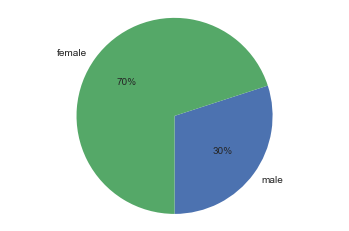

In [40]:
# Here I want to compute the ratio of female and male over the total - to take into account for model training
# if I have unbalanced classes

no_male=train_data.groupby('gender').size()[1]
no_female=train_data.groupby('gender').size()[2]
perc_male=round(float(no_male)/float(no_male+no_female),2)
perc_female=round(float(no_female)/float(no_male+no_female),2)

# Pie chart
labels = 'male', 'female'
sizes = [perc_male,perc_female]
plt.pie(sizes, explode=None, labels=labels,
        autopct='%1.0f%%',startangle=270)
 
plt.axis('equal')
plt.show()



Here I want to compare the datetime of the training with that of the test set (time span, period of the year etc) to decide on which units to take into account for feature engineering.

In [41]:
min_t_train = train_data['click_time'].min()
max_t_train = train_data['click_time'].max()

In [42]:
min_t_test = test_data['click_time'].min()
max_t_test = test_data['click_time'].max()

In [43]:
# Convert posix time into datetime

min_t_train_ep = pd.to_datetime(min_t_train, unit='ms')
max_t_train_ep = pd.to_datetime(max_t_train, unit='ms')

min_t_test_ep = pd.to_datetime(min_t_test, unit='ms')
max_t_test_ep = pd.to_datetime(max_t_test, unit='ms')

tot_day_train = (max_t_train - min_t_train)/1000/3600/24 #seconds
tot_day_test = (max_t_test - min_t_test)/1000/3600/24
print(tot_day_train,tot_day_test)
print(min_t_train_ep,max_t_train_ep)
print(min_t_test_ep,max_t_test_ep)

38.2019419213 9.52874851852
2017-07-10 17:09:11.142000 2017-08-17 21:59:58.924000
2017-07-01 22:00:00 2017-07-11 10:41:23.872000


### Feature Generation

**Fraction of Male and Female Visitors per Page**

Metric of "maleness" and "femaleness" for each page.

How: I build a function to compute the fraction of male page visitors on the total visitors per page. I don't take into account female fraction as it is just 1 - male_fraction, hence the same feature. 

In [44]:
def get_male_page(rows):
    no_visitors = rows.client_id.unique().size # size includes NaN, count doesn't
    return rows[rows.gender == 1]["client_id"].unique().size / no_visitors
    #rows with all page path filtered 
male_page = train_data.groupby('page_path').apply(get_male_page) #two columns 


In [45]:
train_data = train_data.join(male_page.to_frame(name="page_frac_male"), on="page_path", how="right") # why right? because 
#I want to keep all page_frac_male and join train-data on the common values
train_data.head()

,client_id,host_name,page_path,click_time,gender,page_frac_male
0,ef90dd347a4d9c6ab54b2260c0ead5c52ebe480982aadc...,www.lesara.it,54fc1f523d80f473504ec21537ea4fdfaca8ae7d151a5c...,1502970344047,2,0.194888
50,ef90dd347a4d9c6ab54b2260c0ead5c52ebe480982aadc...,www.lesara.it,54fc1f523d80f473504ec21537ea4fdfaca8ae7d151a5c...,1502970403859,2,0.194888
313,ef90dd347a4d9c6ab54b2260c0ead5c52ebe480982aadc...,www.lesara.it,54fc1f523d80f473504ec21537ea4fdfaca8ae7d151a5c...,1502970607921,2,0.194888
591,ef90dd347a4d9c6ab54b2260c0ead5c52ebe480982aadc...,www.lesara.it,54fc1f523d80f473504ec21537ea4fdfaca8ae7d151a5c...,1502970800486,2,0.194888
669,ef90dd347a4d9c6ab54b2260c0ead5c52ebe480982aadc...,www.lesara.it,54fc1f523d80f473504ec21537ea4fdfaca8ae7d151a5c...,1502970845638,2,0.194888


In [46]:
train_data = train_data.sort_values(by=['client_id','click_time'], ascending=True)

In [49]:
avg_male = train_data.groupby("client_id").agg({"page_frac_male": "mean"})
var_male = train_data.groupby("client_id").agg({"page_frac_male": "var"})


var_male.head()

,page_frac_male
client_id,
00015b2ca0bc82750b4e306899d5ff2ea4d304a3795e3aecce84c333,0.000867
0002890fbe79c2a9fef6436f3e4b09f919386bb34b27a0d69544b569,0.070301
0003549f24d6fb2695f73e63708dd9c3e4cfd362f956db0a04ad8cac,0.001559
00037e40777e886343763c750f8a95e338be0cb970e80f5f52b1ea54,0.002549
000502d1f19fb52fe9f7b72911cc009a0ea17569ad83034ac47820d4,0.014046


**Number of Clicks per Day** 

How: I normalize the number of clicks per day for unique clients

In [13]:
click_per_day = (train_data[['client_id','page_path']].groupby('client_id').agg('count'))/tot_day_train
click_per_day['click/day'] = click_per_day['page_path']
del click_per_day['page_path']
click_per_day.head()

,click/day
client_id,
00015b2ca0bc82750b4e306899d5ff2ea4d304a3795e3aecce84c333,0.130883
0002890fbe79c2a9fef6436f3e4b09f919386bb34b27a0d69544b569,0.340297
0003549f24d6fb2695f73e63708dd9c3e4cfd362f956db0a04ad8cac,0.183237
00037e40777e886343763c750f8a95e338be0cb970e80f5f52b1ea54,1.335011
000502d1f19fb52fe9f7b72911cc009a0ea17569ad83034ac47820d4,0.497357


**Number of Sessions per Day**

How: I define a session as the timedelta between two consecutive times, if equal or bigger than 30min (standard Google Analytics metric). In order to derive this feature, I build a function that computes the difference between consecutive values, then I select only those values bigger than 30min and sum up the true values. To avoid counting a single click as zero session, I add 1 to each sum.

In [14]:
def get_no_session(rows):
    delta_click = rows.diff()
    return (delta_click > 1800000).sum() + 1
    
no_sessions_per_day = train_data.groupby('client_id').agg({'click_time': get_no_session})/tot_day_train

In [15]:
no_sessions_per_day['no_sessions/day'] = no_sessions_per_day['click_time']
del no_sessions_per_day['click_time']
no_sessions_per_day.head()

,no_sessions/day
client_id,
00015b2ca0bc82750b4e306899d5ff2ea4d304a3795e3aecce84c333,0.104707
0002890fbe79c2a9fef6436f3e4b09f919386bb34b27a0d69544b569,0.130883
0003549f24d6fb2695f73e63708dd9c3e4cfd362f956db0a04ad8cac,0.026177
00037e40777e886343763c750f8a95e338be0cb970e80f5f52b1ea54,0.052353
000502d1f19fb52fe9f7b72911cc009a0ea17569ad83034ac47820d4,0.104707


**Average time spent on page view**

How: I build a function that computes the difference between consecutive values and then I select only those values smaller than 30min (this way I take into account only the timedeltas within sessions) and sum up the values.

In [16]:
def get_time_view(rows):
    no_clicks = rows.count()
    delta_click = rows.diff()
    return (delta_click[delta_click <= 1800000]).sum() / no_clicks

time_spent_view= train_data.groupby('client_id').agg({'click_time': get_time_view})

In [17]:
time_spent_view['avg_time_page [min]'] = (time_spent_view['click_time'])/60000 #minutes
del time_spent_view['click_time']
time_spent_view.head(5)

,avg_time_page [min]
client_id,
00015b2ca0bc82750b4e306899d5ff2ea4d304a3795e3aecce84c333,0.041663
0002890fbe79c2a9fef6436f3e4b09f919386bb34b27a0d69544b569,0.778121
0003549f24d6fb2695f73e63708dd9c3e4cfd362f956db0a04ad8cac,1.065279
00037e40777e886343763c750f8a95e338be0cb970e80f5f52b1ea54,0.780762
000502d1f19fb52fe9f7b72911cc009a0ea17569ad83034ac47820d4,0.806754


In [18]:
time_spent_view.describe()

,avg_time_page [min]
count,84252.000000
mean,0.826849
std,0.715912
min,0.000024
25%,0.415338
50%,0.677985
75%,1.024787
max,14.800000


Merge the generated user features into a single dataframe

In [19]:
train_data_red = train_data[['client_id','gender']].drop_duplicates().set_index('client_id')
train_data_red.shape

(94594, 1)

In [20]:
train_data_merged = train_data_red\
    .merge(click_per_day, how='outer', left_index=True, right_index=True)\
    .merge(no_sessions_per_day,how='outer', left_index=True, right_index=True)\
    .merge(time_spent_view, how='outer', left_index=True, right_index=True)\
    .merge(avg_male, how='outer', left_index=True, right_index=True)

In [21]:
train_data_merged.head()

,gender,click/day,no_sessions/day,avg_time_page [min],page_frac_male
client_id,,,,,
00015b2ca0bc82750b4e306899d5ff2ea4d304a3795e3aecce84c333,1,0.130883,0.104707,0.041663,0.297714
0002890fbe79c2a9fef6436f3e4b09f919386bb34b27a0d69544b569,1,0.340297,0.130883,0.778121,0.548058
0003549f24d6fb2695f73e63708dd9c3e4cfd362f956db0a04ad8cac,2,0.183237,0.026177,1.065279,0.284089
00037e40777e886343763c750f8a95e338be0cb970e80f5f52b1ea54,2,1.335011,0.052353,0.780762,0.252776
000502d1f19fb52fe9f7b72911cc009a0ea17569ad83034ac47820d4,2,0.497357,0.104707,0.806754,0.229509


## 4. Feature Standardization

In [22]:
features = ['click/day', 'no_sessions/day', 'avg_time_page [min]', 'page_frac_male']

In [23]:
means = train_data_merged.mean(axis=0)
stds = train_data_merged.std(axis=0)

In [24]:
train_data_merged[features] = (train_data_merged[features] - means[features]) / stds[features]

In [25]:
train_data_merged.head()

,gender,click/day,no_sessions/day,avg_time_page [min],page_frac_male
client_id,,,,,
00015b2ca0bc82750b4e306899d5ff2ea4d304a3795e3aecce84c333,1,-0.502503,0.029326,-1.096764,0.012418
0002890fbe79c2a9fef6436f3e4b09f919386bb34b27a0d69544b569,1,-0.352022,0.230401,-0.068065,1.960281
0003549f24d6fb2695f73e63708dd9c3e4cfd362f956db0a04ad8cac,2,-0.464883,-0.573900,0.333043,-0.093595
00037e40777e886343763c750f8a95e338be0cb970e80f5f52b1ea54,2,0.362763,-0.372825,-0.064375,-0.337229
000502d1f19fb52fe9f7b72911cc009a0ea17569ad83034ac47820d4,2,-0.239161,0.029326,-0.028070,-0.518261


In [26]:
train_data_merged.describe()

,gender,click/day,no_sessions/day,avg_time_page [min],page_frac_male
count,94594.000000,9.459400e+04,9.459400e+04,8.425200e+04,9.459400e+04
mean,1.693490,3.246216e-13,5.037990e-13,5.092496e-15,1.525036e-15
std,0.461046,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-5.777437e-01,-5.738999e-01,-1.154926e+00,-2.304013e+00
25%,1.000000,-5.025032e-01,-5.738999e-01,-5.748067e-01,-4.875858e-01
50%,2.000000,-3.144018e-01,-3.728247e-01,-2.079373e-01,-1.846268e-01
75%,2.000000,9.942127e-02,2.932568e-02,2.764829e-01,2.495098e-01
max,2.000000,7.061863e+01,2.717448e+01,1.951798e+01,5.476722e+00


In [27]:
train_data_merged['click/day'].corr(train_data_merged['avg_time_page [min]'])

0.047700629910847371

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1167aaba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1192e09e8>]], dtype=object)

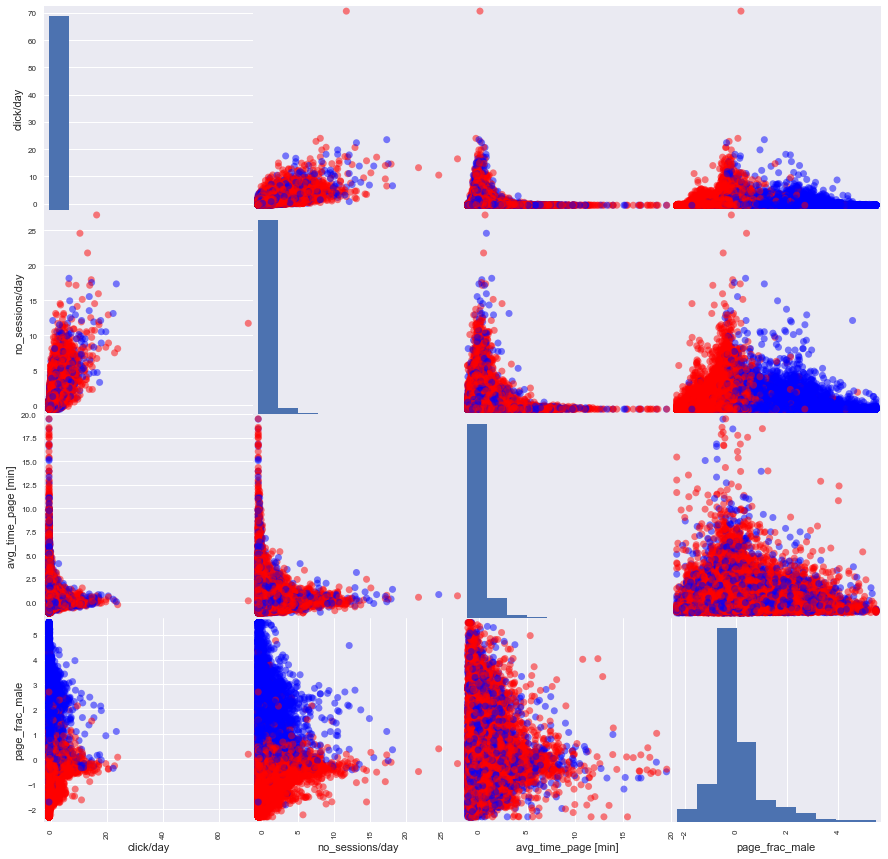

In [28]:
col_map={1: "blue", 2: "red"}
cols=list(map(lambda x:col_map.get(x),train_data_merged.gender))
pd.plotting.scatter_matrix(train_data_merged[features], 
               figsize=(15, 15), marker='o', c=cols)

## 5. Model Training and Prediction
This problem is a supervised classification problem, as we want to predict either gender male or female and we are training our model with a given dataset. 
Gender is unbalanced (ca. 70% female, 30% male) so we need to balance the training examples when training.

In [29]:
# Identifying X and Y in the training dataset: as my model predicts the user gender, my Y will be the gender column
X_train = train_data_merged[features]
y_train = train_data_merged['gender']

In [30]:
X_train[X_train['avg_time_page [min]'].isnull()]

,click/day,no_sessions/day,avg_time_page [min],page_frac_male
client_id,,,,
001ff79cb3429cfdd4ea42f81f394f90838f560aa4b615dfff72f760,-0.540123,-0.171750,NaN,0.261405
002bf91855b9376496734c1d212627f42fcbea982ac5a706140a2e67,-0.577744,-0.573900,NaN,-0.747866
002d04da7634441a40c99a4aaf1c261e172c272b4fbe0d6ce7f968ca,-0.577744,-0.573900,NaN,1.213305
002ee253fa9e375661665d632e7f28fcd198459654e5cdebe0478105,-0.577744,-0.573900,NaN,0.930584
00304bc02571ae3bb11a46cc9023e20817409fb4cbde7d86e5b6d773,-0.577744,-0.573900,NaN,-0.181995
00310fc7fe6bf9d5ed87950da9416aa7e6e093ca01c84e9959284ccc,-0.577744,-0.573900,NaN,1.798556
0038a503d92eabf7bc06bcf29e5cf280b84499a70defd42e7fe2bc1c,-0.558934,-0.372825,NaN,-0.653554
003fab495332266f94060f4a8ccb9cd1b7b6e1872119550092733bad,-0.577744,-0.573900,NaN,-0.334998
005af7e1ffa0ece559abeef33ed4856f484235e0a402b5540b475ffb,-0.577744,-0.573900,NaN,0.179762


In [ ]:
# Logistic Regression
del X_train['avg_time_page [min]']
logreg = LogisticRegression(class_weight='balanced', scoring='roc_auc')
cross_val_score(logreg, X_train, y_train, cv=3)

In [35]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [33]:
# Support Vector Machine
from sklearn.svm import SVC, LinearSVC
svc = SVC()
cross_val_score(svc, X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
cross_val_score(rf, X_train, y_train)


In [ ]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01)
cross_val_score(gb, X_train, y_train)

## 6. Predict on Test Data

In [ ]:
test_data = test_data.join(male_page.to_frame(name="page_frac_male"), on="page_path", how="right")
test_data.head()

In [ ]:
# Check if the pages in the train set are the same here - to check because I don't have gender in the test set
test_data.page_frac_male.isnull().sum()

In [ ]:
test_data = test_data.sort_values(by=['client_id','click_time'], ascending=True)

**Computing Features**

In [ ]:
test_avg_male = test_data.groupby("client_id").agg({"page_frac_male": "mean"})
test_avg_male.head()

In [ ]:
test_click_per_day = (test_data[['client_id','page_path']].groupby('client_id').agg('count')) / tot_day_test
test_click_per_day['click/day'] = test_click_per_day['page_path']
del test_click_per_day['page_path']
test_click_per_day.head()

In [ ]:
test_no_sessions_per_day = test_data.groupby('client_id').agg({'click_time': get_no_session}) / tot_day_test
test_no_sessions_per_day['no_sessions/day'] = test_no_sessions_per_day['click_time']
del test_no_sessions_per_day['click_time']
test_no_sessions_per_day.head()

In [ ]:
test_time_spent_view = test_data.groupby('client_id').agg({'click_time': get_time_view})
test_time_spent_view['avg_time_page [min]'] = (test_time_spent_view['click_time']) / 60000 #minutes
del test_time_spent_view['click_time']
test_time_spent_view.head()

In [ ]:
test_time_spent_view.describe()

In [ ]:
test_data_merged = test_avg_male\
    .merge(test_click_per_day, how='outer', left_index=True, right_index=True)\
    .merge(test_no_sessions_per_day, how='outer', left_index=True, right_index=True)\
    .merge(test_time_spent_view, how='outer', left_index=True, right_index=True)

In [ ]:
test_data_merged.head()

**Feature standardization - test dataset**

In [ ]:
test_data_merged[features] = (test_data_merged[features] - means[features]) / stds[features]

In [ ]:
test_data_merged.describe()

In [ ]:
X_test = test_data_merged[features]

In [ ]:
test_data_merged['gender_predicted'] = logreg.predict(X_test)

In [ ]:
test_data_merged.head()

## 7. Export the Predicted Results

In [ ]:
test_data_merged.to_csv('gender_predicted.csv', columns=['gender_predicted'])